In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
#from datetime as date

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
inspector=inspect(engine)
inspector.get_table_names()
# reflect the tables

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
# reflect an existing database into a new model
Base= automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [9]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [10]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date #2017-08-23 # ISO Format

# Calculate the date 1 year ago from the last data point in the database
## REVIEW THE DATE IS OFF
year_ago=dt.date(2017,8,23)-dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
sel=[Measurement.date,Measurement.prcp]
results= session.query(*sel).filter(Measurement.date >= year_ago).all()
#len(results)
results

# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(results)
#df
df_one=df.set_index('date')

# Sort the dataframe by date
df_one.sort_index()

# rename prcp to precipitation:

df_one.rename(columns={'prcp':'precipitation'}, inplace=True)
#print(df_one.columns)
df_one

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


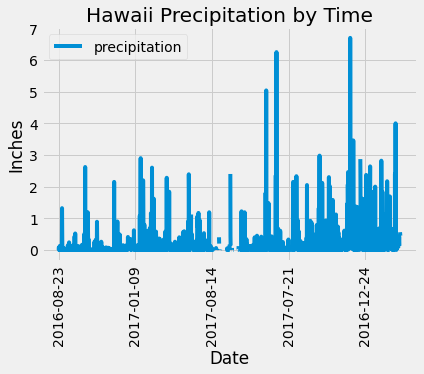

In [55]:
# Use Pandas Plotting with Matplotlib to plot the data
df_one.plot(y='precipitation')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Inches')
plt.title("Hawaii Precipitation by Time")
#plt.legend("precipitation", loc=2)
plt.savefig('Precipiation.png')

In [56]:
# Use Pandas to calcualte the summary statistics for the precipitation date
df_one.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [59]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(func.count(Station.station)).all()
station_count

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#use .group_by, .order_by, .desc(), .all()

measurement_count=session.query(Measurement.station,func.count(Measurement.date))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.date).desc()).all()
measurement_count


# station_activity=session.query(Measurement.station, station_count)\
# .group_by(Measurement.station).order_by(station_count.desc()).all()

# station_activity




[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# station_min=func.min(Measurement.tobs).label('station_min')
# station_max=func.max(Measurement.tobs).label('station_max')
# station_mean=func.avg(Measurement.tobs).label('station_mean')

most_active_station=measurement_count[0][0]
most_active_station #most active is 'USC00519281'

sel=[func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

results=session.query(*sel).filter(Measurement.station==most_active_station).all()
results




[(54.0, 85.0, 71.66378066378067)]

In [19]:
#df=pd.DataFrame(results)
#df

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel=[Measurement.station, Measurement.date, Measurement.tobs]
results=session.query(*sel).filter(Measurement.date>=year_ago).filter(Measurement.station==most_active_station).all()
results

df_most_active=pd.DataFrame(results)

column_names={'station':'Station', 'date':'Date', 'tobs':'Temperature'}
df_most_active=df_most_active.rename(columns=column_names)

df_most_active.head()



,Station,Date,Temperature
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0


In [21]:
#df_one

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


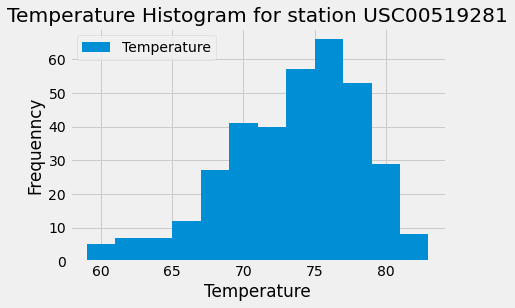

In [94]:
# plot using a histogram:
df_most_active.plot(kind='hist',bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequenncy')
plt.title(f'Temperature Histogram for station {most_active_station}')
plt.savefig('Temperature Histogram.png')

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
